In [18]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import os

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Load the data in folder data
path = "drive/MyDrive/Calculo/dataset/loan"
files = os.listdir(path)
df = pd.DataFrame()
for file in files:
    if file.endswith(".csv"):
        data = pd.read_csv(path + "/" + file)
        df = pd.concat([df, data])

# **1. Geração de Dados Simulados**

* **Variável x:** é uma sequência de valores igualmente espaçados entre -100 e 100, representando a variável independente.
* **Variável y:** corresponde aos valores da coluna loan_status do DataFrame df, que são reformatados e convertidos para o tipo float32.
* **Rótulos Binários labels:** utiliza um limiar de 0,5 para criar rótulos binários. Valores acima de 0,5 são atribuídos à classe 1; valores iguais ou inferiores são atribuídos à classe 0.

## **Objetivo**

Simular dados de entrada e saída para um problema de classificação binária.

In [21]:
def generate_data(n_points=len(df["loan_status"])):
    x = tf.linspace(-100.0, 100.0, n_points)

    # Função linear para separar as classes
    y = tf.cast(tf.reshape(df["loan_status"].values, (-1, 1)), dtype=tf.float32)  # 0 ou 1 como saída

    # Criando rótulos binários: se y > 0, então classe 1, caso contrário, classe 0
    labels = tf.where(y > 0.5, 1, 0)
    # print(tf.reshape(x, (-1, 1)), tf.reshape(labels, (-1, 1)))
    return tf.reshape(x, (-1, 1)), tf.reshape(labels, (-1, 1))

# Gerando os dados
x_train, y_train = generate_data()

# **2. Definição do Modelo de Rede Neural**

O modelo é implementado como uma rede neural sequencial com três camadas densas:

## **Arquitetura**

* Duas camadas ocultas densas, cada uma com 10 neurônios e função de ativação ReLU (Rectified Linear Unit).
* Uma camada de saída com 1 neurônio e ativação sigmoide, adequada para produzir uma probabilidade (saída entre 0 e 1).

**Entrada:** Um único valor (dimensão 1) por amostra, como especificado em input_shape=(1,).

**Saída:** Probabilidade associada à classe 1.



In [22]:
# Definindo o modelo da rede neural
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid para saída de probabilidade
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **3. Compilação e Treinamento do Modelo**

O modelo é compilado e treinado utilizando os seguintes parâmetros:

* **Otimizador:** Adam, que combina as vantagens do RMSprop e do Gradiente Descendente com momento.
* **Função de Perda:** Binary Cross-Entropy, ideal para problemas de classificação binária, pois mede a divergência entre as distribuições verdadeira e predita.
* **Métrica:** Acurácia, que calcula a proporção de predições corretas.
Número de Épocas: 1000, permitindo aprendizado contínuo sobre o conjunto de treinamento.

In [36]:
# Compilando o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Treinando o modelo
model.fit(x_train, y_train, epochs=500, verbose=0)


# **4. Predição para Novos Pontos**

Após o treinamento, o modelo é utilizado para prever as probabilidades de classe para dois novos pontos de entrada (101 e 102):

**Entrada x_test:** valores para os quais se deseja prever a classe.

**Saída y_pred_proba:** probabilidades associadas à classe 1.

Essas probabilidades podem ser convertidas em rótulos binários utilizando um limiar (por exemplo, 0,5).

In [37]:
# Dados para prever os próximos dois pontos
x_test = tf.constant([[101], [102]], dtype=tf.float32)
y_pred_proba = model.predict(x_test)
y_pred = tf.round(y_pred_proba)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


# **6. Avaliação do Modelo**

### **Cálculo de Acurácia:**

\begin{align}
    Accuracy = \frac{\text{Número de Predição Corretas}}{\text{Número Total de Amostras}} = \frac{\text{VP + VN}}{\text{VP + VN + FP + FN}}
\end{align}

A acurácia mede a proporção de predições corretas.

Um modelo perfeito teria zero falsos positivos e zero falsos negativos e, portanto, uma precisão de 1,0 ou 100%.

### **Calculo de F1-Score:**

O F1-Score avalia o equilíbrio entre precisão e recall, especialmente útil para conjuntos de dados desbalanceados.

* **Precisão**  é a proporção de todas as classificações positivas do modelo que são realmente positivas. Ela é matematicamente definida como:

\begin{align}
    Precisão = \frac{\text{VP}}{\text{VP} + \text{FP}}
\end{align}

* **Recall** é a proporção de todos os positivos reais que foram classificados corretamente como positivos. O recall é matematicamente definido como:

\begin{align}
    Recall = \frac{\text{VP}}{\text{VP} + \text{FN}}
\end{align}

* **F1-Score** é definido como média harmônica de precisão e recall, avalia o desempenho de modelos de classificação, equilibrando a penalização de falsos positivos e negativos, sendo especialmente útil em cenários desbalanceados.

\begin{align}
    F1 = 2 ⋅ \text{ }\frac{\text{Precisão} \cdot \text{Recall} }{\text{Precisão} + \text{Recall}}
\end{align}


# **7. Visualização dos Resultados**

O gráfico exibe os rótulos dos dados de treinamento e as predições dos novos pontos de entrada.

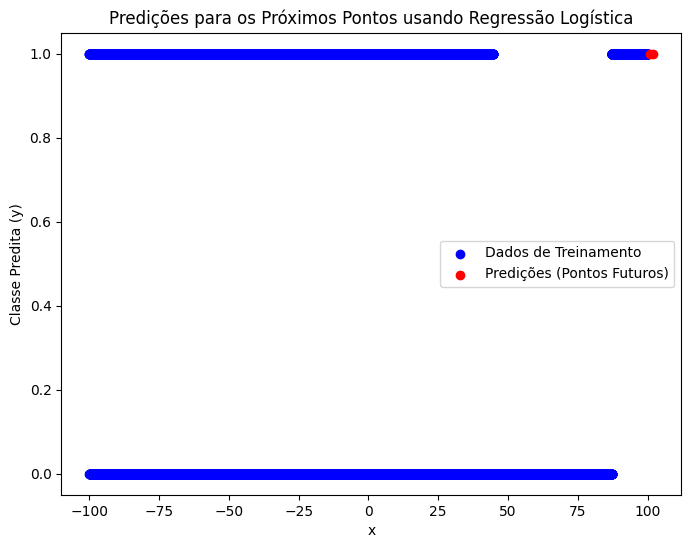

In [25]:
# Plotando o resultado
plt.figure(figsize=(8, 6))

# Plotando os dados de treinamento
plt.scatter(x_train, y_train, color='blue', label='Dados de Treinamento')

# Plotando os dados previstos
plt.scatter(x_test, y_pred, color='red', label='Predições (Pontos Futuros)')

# Configuração do gráfico
plt.xlabel('x')
plt.ylabel('Classe Predita (y)')
plt.title('Predições para os Próximos Pontos usando Regressão Logística')
plt.legend()
plt.show()


In [48]:
accuracy, loss, precision, recall = model.evaluate(x_train, y_train)

print(f"Accuracy: {accuracy:.2f}")
print(f"Loss: {loss:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)  # Evita divisão por zero
print(f"F1Score: {f1_score:.2f}")


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7574 - loss: 0.5167 - precision: 0.0646 - recall: 0.0103
Accuracy: 0.38
Loss: 0.84
Precision: 1.00
Recall: 0.28
F1Score: 0.44
